In [1]:
from astropy.time import Time, TimeDelta
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import moviepy.editor as mpy
from moviepy.video.io.bindings import mplfig_to_npimage
import h5py
import numpy as np
import os
import glob
import pandas as pd
import scipy.stats as st
import sunpy.coordinates.sun as sn
from scipy.ndimage import gaussian_filter1d

import huxt as H
import huxt_analysis as HA
import huxt_inputs as HIN
import GeoModelUncertainty as gmu

Files already exist for CR2071
Files already exist for CR2071
Files already exist for CR2071


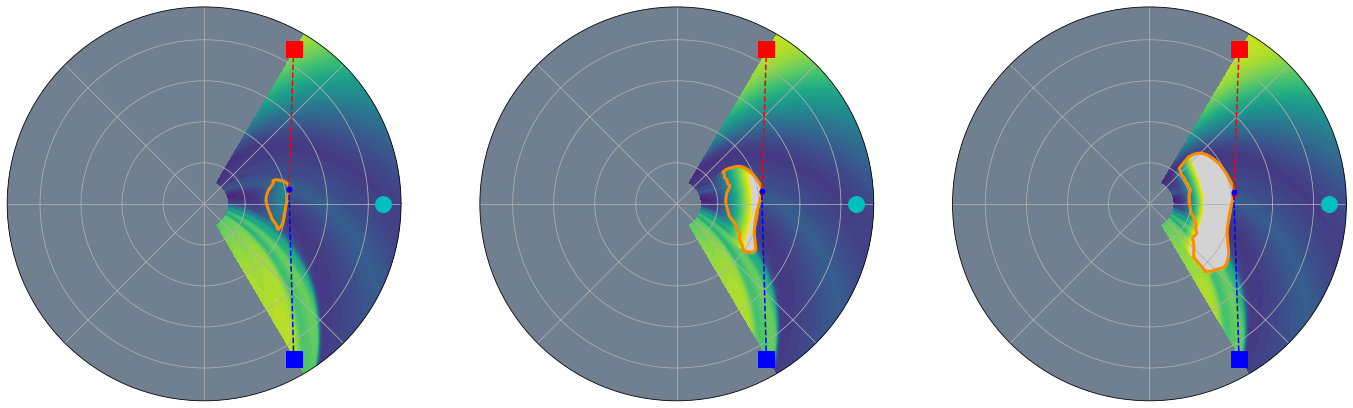

In [4]:
# Set up HUXt to run all three scenarios in uniform wind, then plot the kinematics out.
cme_scenarios = gmu.load_cme_scenarios()

fig, ax = plt.subplots(1, 3, figsize=(24, 8), subplot_kw={"projection": "polar"})
for i, s_key in enumerate(['average', 'fast', 'extreme']):
    
    scenario = cme_scenarios[s_key]
    start_time = Time('2008-06-10T00:00:00')
    cr_num = np.fix(sn.carrington_rotation_number(start_time))
    ert = H.Observer('EARTH', start_time)
    vr_in = HIN.get_MAS_long_profile(cr_num, ert.lat.to(u.deg))
    #vr_in = vr_in*0 + 400*(u.km/u.s)
    model = H.HUXt(v_boundary=vr_in, cr_num=cr_num, cr_lon_init=ert.lon_c, latitude=ert.lat.to(u.deg),
                   lon_start=300*u.deg, lon_stop=60*u.deg, simtime=5*u.day, dt_scale=1)
    
    t_launch = (1*u.hr).to(u.s)
    cme = H.ConeCME(t_launch=t_launch, longitude=0*u.deg, latitude=model.latitude.to(u.deg),
                    width=scenario['width'], v=scenario['speed'], thickness=0.1*u.solRad)

    # Solve HUXt and get CME object
    model.solve([cme])
    cme = model.cmes[0]
    
    #Track the CMEs apex kinematics
    apex = gmu.compute_apex_profile(model, cme)
    
    # Observe the CME from L4 and L5
    l4obs = gmu.Observer(model, 60.0*u.deg, el_min=4.0, el_max=40.0, color='r', name='L4')
    l5obs = gmu.Observer(model, 300.0*u.deg, el_min=4.0, el_max=40.0, color='b', name='L5')
    
    observer_list = [l4obs, l5obs]
    
    # Plot solution when CME gets to 100rs
    id_t = np.argmin(np.abs(apex['r'] - 100*u.solRad.to(u.km)))
    gmu.plot_huxt_with_observer_multi(model.time_out[id_t], model, observer_list, ax[i])

In [ ]:
def produce_huxt_ensemble():    
    
    cme_scenarios = load_cme_scenarios()

    # Get array of random model initialisation times
    np.random.seed(47041547)
    start_times = get_model_initialisation_times()

    # Set which longitudes to observe the CME from. 90'
    observer_longitudes = (360 + np.arange(-10, -100, -10))*u.deg

    # Open HDF5 for output statistics
    out_file = create_output_hdf5()

    # Loop over cme scenarios
    for scenario_key, scenario in cme_scenarios.items():

        cme_group = out_file.create_group(scenario_key)

        # Now loop through initialisations
        for i, start_time in enumerate(start_times):

            run_group = cme_group.create_group("run_{:03d}".format(i))

            # Initialise HUXt at this start time
            model = setup_huxt(start_time)

            # Set up the ConeCME
            t_launch = (1*u.hr).to(u.s)
            cme = H.ConeCME(t_launch=t_launch, longitude=0*u.deg, latitude=model.latitude.to(u.deg),
                            width=scenario['width'], v=scenario['speed'], thickness=1*u.solRad)

            # Solve HUXt and get CME object
            model.solve([cme])
            cme = model.cmes[0]

            hdf5_save_cme(run_group, cme)
            hdf5_save_arrival_stats(run_group, cme)
            hdf5_save_apex_profile(run_group, model, cme)
            hdf5_save_solarwind_timeseries(run_group, model)

            # Setup group to hold all observers 
            all_observers_group = run_group.create_group('observers')
            dset = all_observers_group.create_dataset("observer_lons", data=observer_longitudes.value)
            dset.attrs['unit'] = observer_longitudes.unit.to_string()
            # Loop through observer longitudes, get each observer, save to file
            for obs_lon in observer_longitudes:

                obs_name = "Observer {:3.2f}".format(obs_lon.value)
                observer = Observer(model, obs_lon, el_min=4.0, el_max=40.0, name=obs_name)
                hdf5_save_observer(all_observers_group, observer)         

            out_file.flush()

            # Make summary plot of arrival
            arrival_stats = cme.compute_arrival_at_body('EARTH')
            if arrival_stats['hit']:
                proj_dirs = get_project_dirs()
                hit_id = arrival_stats['hit_id']
                fig, ax = plot_huxt_no_observer(model.time_out[hit_id], model)
                fig_name = 'run_{:03d}_{}_arrival.png'.format(i, scenario_key)
                fig_path = os.path.join(proj_dirs['HUXt_figures'], fig_name)
                fig.savefig(fig_path)
                plt.close('all')

    out_file.close()
    return




In [ ]:
cme_scenarios = gmu.load_cme_scenarios()

# Get array of random model initialisation times
np.random.seed(47041547)
start_times = gmu.get_model_initialisation_times()

# Set which longitudes to observe the CME from. 90'
observer_longitudes = (360 + np.arange(-10, -100, -10))*u.deg

# Open HDF5 for output statistics
out_file = gmu.create_output_hdf5()

# Loop over cme scenarios
for scenario_key, scenario in cme_scenarios.items():
    
    cme_group = out_file.create_group(scenario_key)
        
    # Now loop through initialisations
    for i, start_time in enumerate(start_times):
        
        run_group = cme_group.create_group("run_{:03d}".format(i))
        
        # Initialise HUXt at this start time
        model = gmu.setup_huxt(start_time)

        # Set up the ConeCME
        t_launch = (1*u.hr).to(u.s)
        cme = H.ConeCME(t_launch=t_launch, longitude=0*u.deg, latitude=model.latitude.to(u.deg),
                        width=scenario['width'], v=scenario['speed'], thickness=1*u.solRad)
        
        # Solve HUXt and get CME object
        model.solve([cme])
        cme = model.cmes[0]
            
        gmu.hdf5_save_cme(run_group, cme)
        
        gmu.hdf5_save_arrival_stats(run_group, cme)
        
        gmu.hdf5_save_apex_profile(run_group, model, cme)
        
        gmu.hdf5_save_solarwind_timeseries(run_group, model)
            
        # Setup group to hold all observers 
        all_observers_group = run_group.create_group('observers')
        dset = all_observers_group.create_dataset("observer_lons", data=observer_longitudes.value)
        dset.attrs['unit'] = observer_longitudes.unit.to_string()
        # Loop through observer longitudes, get each observer, save to file
        for obs_lon in observer_longitudes:
            
            obs_name = "Observer {:3.2f}".format(obs_lon.value)
            observer = gmu.Observer(model, obs_lon, el_min=4.0, el_max=40.0, name=obs_name)
            gmu.hdf5_save_observer(all_observers_group, observer)         
                                    
        out_file.flush()
        
        # Make summary plot of arrival
        arrival_stats = cme.compute_arrival_at_body('EARTH')
        if arrival_stats['hit']:
            proj_dirs = gmu.get_project_dirs()
            hit_id = arrival_stats['hit_id']
            fig, ax = gmu.plot_huxt_no_observer(model.time_out[hit_id], model)
            fig_name = 'run_{:03d}_{}_arrival.png'.format(i, scenario_key)
            fig_path = os.path.join(proj_dirs['HUXt_figures'], fig_name)
            fig.savefig(fig_path)
            plt.close('all')
    
out_file.close()
                                 
                        